In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

---
Load Libraries

In [ ]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-3-465a1193f71c>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

---
Set Global Variables

In [ ]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [ ]:
# setup model configurations
config = {
    # general information
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "BiLSTM",
    "sem-space": 'attr',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 32,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 42, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 64,
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "freq": 50,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,
}

In [ ]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

In [ ]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-9-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-1


---
Load Data

In [ ]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2Reader(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [ ]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [ ]:
# load video dataset
Attr_data_path  = data_root+'/Attribute/PAMAP2_attributes.json'
activity_dict, attribute_dict, attr_mat = load_attribute(Attr_data_path)
_, attr_size = attr_mat.shape

---
Utils

In [ ]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [ ]:
## IMU Dataset

class IMUDataset(Dataset):
    def __init__(self, data, actions, attributes, action_classes):
        super(IMUDataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        y_feat = self.attributes[target, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]
    
    def getClassFeatures(self):
        cls_feat = self.attributes[self.action_classes, ...]
        return cls_feat

In [ ]:
## IMU Encoder Model

class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=dropout)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

In [ ]:
def loss_cross_entropy(y_pred, cls, selected_features, loss_fn=nn.CrossEntropyLoss(reduction="mean")):
    num_classes = selected_features.size()[0]
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb,cls)
    return loss

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    _, feature_size = y_pred.size()
    loss = loss_fn(y_pred, y_feat)*(1/feature_size)
    return loss

def predict_class(y_pred, selected_features):
    num_classes = selected_features.size()[0]
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [ ]:
def train_step(model, dataloader, dataset, optimizer, loss_module, device, phase='train', loss_alpha=0.7):
    model = model.train()
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0, "accuracy": 0}
    semantic_space = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), semantic_space, loss_fn=loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])
                loss = feat_loss + loss_alpha*class_loss

            class_output = predict_class(feat_output, semantic_space)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                N = len(targets)
                metrics['loss'] = loss.item()/N # add total loss of batch
                metrics['feat. loss'] = feat_loss.item()/N
                metrics['classi. loss'] = class_loss.item()/N

            # convert feature vector into action class
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class, normalize=True)
            tepoch.set_postfix(metrics)   
    
    # metrics['accuracy'] = metrics['accuracy']/metrics['samples'] # average loss per sample for whole epoch
    # tepoch.set_postfix(metrics)  
    return metrics

In [ ]:
def eval_step(model, dataloader, dataset, loss_module, device, class_names, phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.1):
    model = model.eval()
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}
    semantic_space = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), semantic_space, loss_fn=loss_module['class'])
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])
                loss = feat_loss + loss_alpha*class_loss
            
            class_output = predict_class(feat_output, semantic_space)

            with torch.no_grad():
                N = len(targets)
                metrics['loss'] += loss.item()/N  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()/N
                metrics['classi. loss'] += class_loss.item()/N

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(class_output.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [ ]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

---
Run

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.341



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.313



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.442



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.428



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.454



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.444



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.424



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.419



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.325



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.297



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.318



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.377



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.589



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.225



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.449



unseen:   0%|          | 0/175 [00:00<?, ?batch/s]

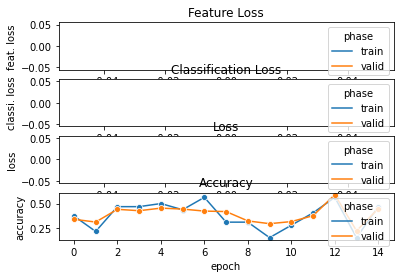

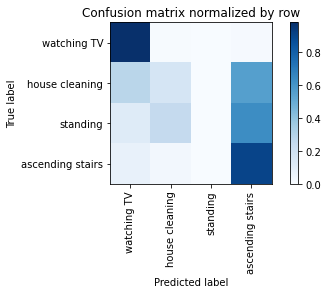

Overall accuracy: 0.373

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.000      0.000      0.000      0.331       1852|	 ascending stairs: 0.632,	house cleaning: 0.247,	watching TV: 0.121,	
  house cleaning       0.384      0.166      0.231      0.329       1841|	 ascending stairs: 0.554,	watching TV: 0.281,	
ascending stairs       0.307      0.902      0.458      0.193       1078|	 watching TV: 0.075,	house cleaning: 0.023,	
     watching TV       0.498      0.982      0.660      0.148        829|	 ascending stairs: 0.011,	house cleaning: 0.007,	

----------------------------------------------------------------------------------------------------
     avg / total       0.259      0.373      0.262        1.0       5600|	      

{'accuracy': 0.37339285714285714, 'precision': 0.2970776500677326, 'recall': 0.5123116251546282, 'f1': 0.33739310433549186, 'samples': 0, 'loss': 46.34240843355656, 'feat. loss': 46.318235203

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.325



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.218



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.222



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.306



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.297



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.345



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.221



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.170



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.387



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.215



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.374



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.389



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.309



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.414



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.443



unseen:   0%|          | 0/173 [00:00<?, ?batch/s]

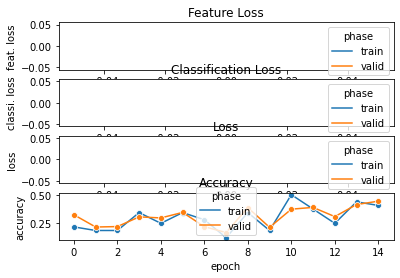

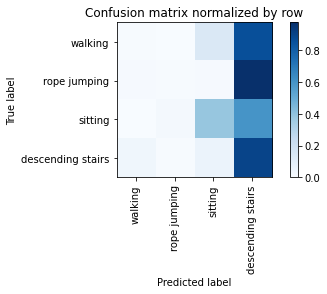

Overall accuracy: 0.279

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.185      0.004      0.008      0.421       2330|	 descending stairs: 0.857,	sitting: 0.139,	
          sitting       0.641      0.381      0.478      0.325       1799|	 descending stairs: 0.595,	rope jumping: 0.022,	
descending stairs       0.194      0.896      0.319      0.171        946|	 sitting: 0.059,	walking: 0.037,	
     rope jumping       0.042      0.004      0.008      0.083        461|	 descending stairs: 0.974,	sitting: 0.011,	walking: 0.011,	

----------------------------------------------------------------------------------------------------
      avg / total       0.323      0.279      0.214        1.0       5536|	      

{'accuracy': 0.27908236994219654, 'precision': 0.2654775640235724, 'recall': 0.32145081319464297, 'f1': 0.2033174575776338, 'samples': 0, 'loss': 38.80613273382187, 'feat. loss': 38.78231829404831, 'classi. los

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.144



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.221



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.165



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.273



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.179



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.265



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.306



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.353



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.261



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.320



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.357



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.418



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.057



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.404



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.560



unseen:   0%|          | 0/222 [00:00<?, ?batch/s]

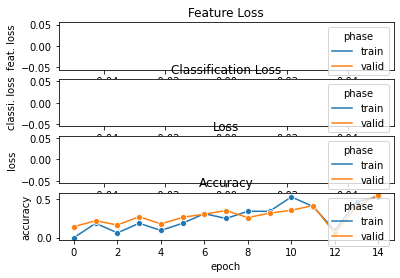

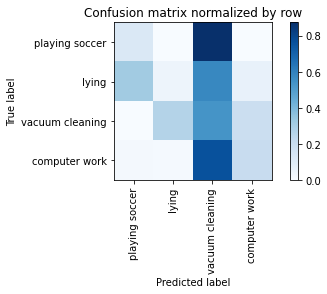

Overall accuracy: 0.240

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.587      0.211      0.311      0.432       3066|	 vacuum cleaning: 0.763,	playing soccer: 0.014,	
          lying       0.139      0.042      0.065      0.264       1876|	 vacuum cleaning: 0.579,	playing soccer: 0.314,	computer work: 0.064,	
vacuum cleaning       0.193      0.538      0.285      0.240       1706|	 lying: 0.266,	computer work: 0.196,	
 playing soccer       0.084      0.127      0.101      0.064        456|	 vacuum cleaning: 0.873,	computer work: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.342      0.240      0.226        1.0       7104|	      

{'accuracy': 0.23958333333333334, 'precision': 0.25076772489837695, 'recall': 0.22954220109010576, 'f1': 0.1902814488024546, 'samples': 0, 'loss': 66.75950863957405, 'feat. loss': 66.72870686650276, 'cla

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.182



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.322



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.383



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.576



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.632



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.567



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.423



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.239



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.472



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.419



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.533



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.677



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.530



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.332



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.284



unseen:   0%|          | 0/137 [00:00<?, ?batch/s]

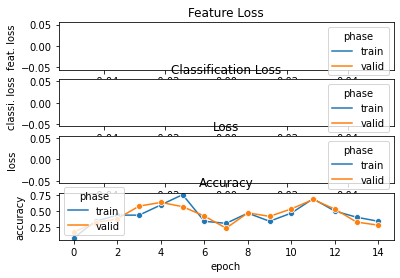

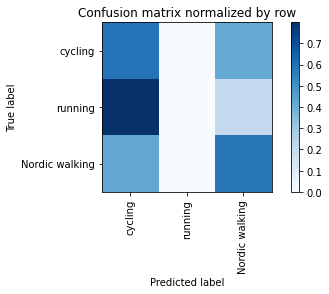

Overall accuracy: 0.457

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.555      0.575      0.565      0.419       1835|	 cycling: 0.425,	running: 0.000,	
       cycling       0.381      0.590      0.463      0.366       1603|	 Nordic walking: 0.410,	running: 0.000,	
       running       0.000      0.000      0.000      0.216        946|	 cycling: 0.799,	Nordic walking: 0.201,	

----------------------------------------------------------------------------------------------------
   avg / total       0.372      0.457      0.406        1.0       4384|	      

{'accuracy': 0.45666058394160586, 'precision': 0.31207038618743294, 'recall': 0.38854010673674416, 'f1': 0.34275977610888303, 'samples': 0, 'loss': 43.03777986764908, 'feat. loss': 43.02275496721268, 'classi. loss': 150.2480572462082}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4, 

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.253



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.304



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.468



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.346



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.242



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.363



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.393



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.358



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.520



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.219



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.503



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.542



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.313



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.425



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.540



unseen:   0%|          | 0/120 [00:00<?, ?batch/s]

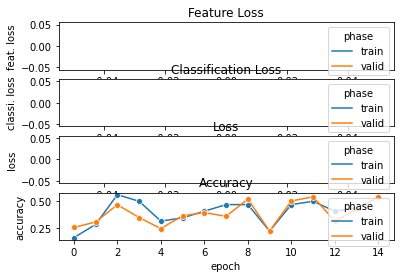

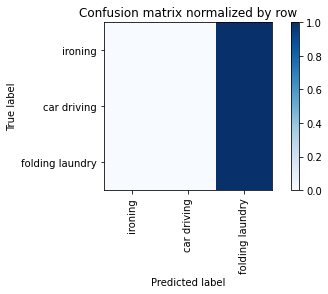

Overall accuracy: 0.253

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.607       2329|	 folding laundry: 1.000,	car driving: 0.000,	
folding laundry       0.253      1.000      0.404      0.253        973|	 car driving: 0.000,	ironing: 0.000,	
    car driving       0.000      0.000      0.000      0.140        538|	 folding laundry: 1.000,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.064      0.253      0.102        1.0       3840|	      

{'accuracy': 0.25338541666666664, 'precision': 0.08446180555555555, 'recall': 0.3333333333333333, 'f1': 0.13477387630722348, 'samples': 0, 'loss': 29.171283081173897, 'feat. loss': 29.158199548721313, 'classi. loss': 130.8352745771408}
============== Overall Unseen Classes Performance ==============
Shutting down background jobs, please wait a moment...


In [ ]:
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.1, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']

    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = IMUDataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = IMUDataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = IMUDataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt, optimizer, loss_module, device, phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'seen-eval', train_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        # if eval_metrics['accuracy'] > best_acc:
        #     best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    # model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
print(seen_score_df.mean())
log('global', '',seen_score_df.mean().to_dict())
run.stop()